In [2]:
import json
import time
import warnings
from qiskit import transpile
from qiskit.quantum_info import Pauli


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

In [3]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [4]:
from qiskit_aer import AerSimulator

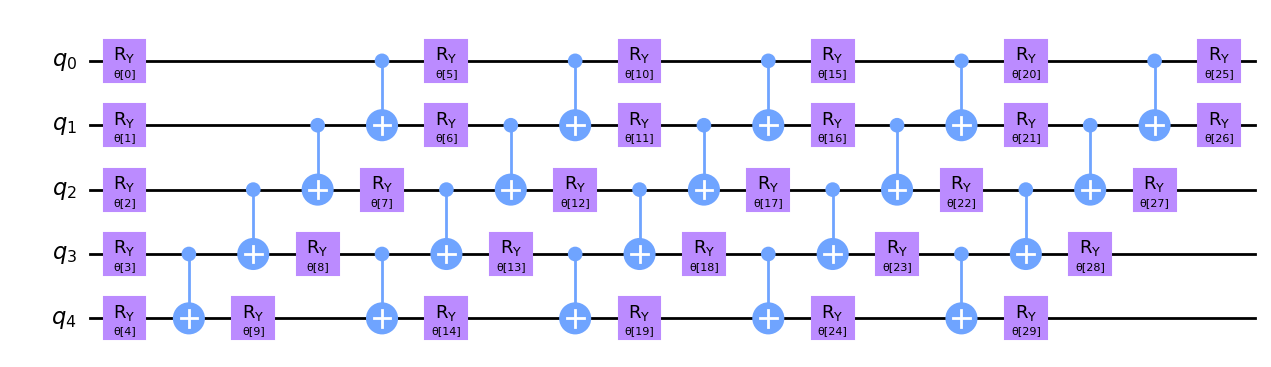

In [5]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

In [6]:
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.providers.basic_provider import BasicSimulator

simulator_basic = BasicSimulator()



In [7]:
pauli_op=SparsePauliOp.from_list([('Z'*(num_latent+num_trash), 1.0)])
pauli_op

SparsePauliOp(['ZZZZZ'],
              coeffs=[1.+0.j])

In [8]:
[0, 1, 2]

[0, 1, 2]

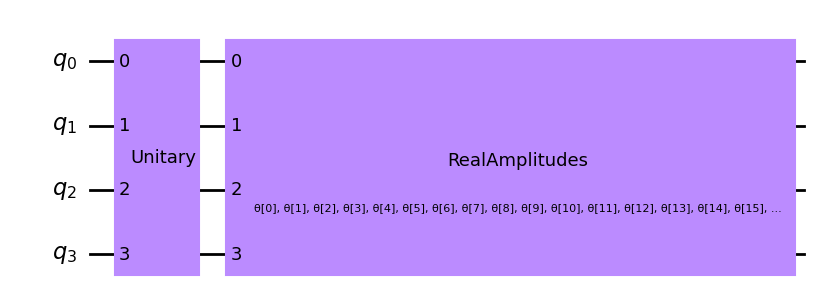

In [15]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + num_trash, "q")
    circuit = QuantumCircuit(qr)

    pauli_op=SparsePauliOp.from_list([('Z'*(num_latent+num_trash), 1.0)])
  
    circuit.unitary(pauli_op,qubits=list(range(num_latent+num_trash)))
    
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)

    return circuit


num_latent = 4
num_trash = 0
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")



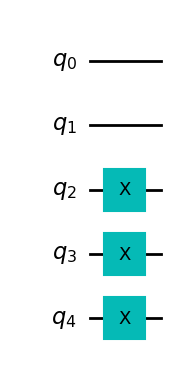

In [6]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")

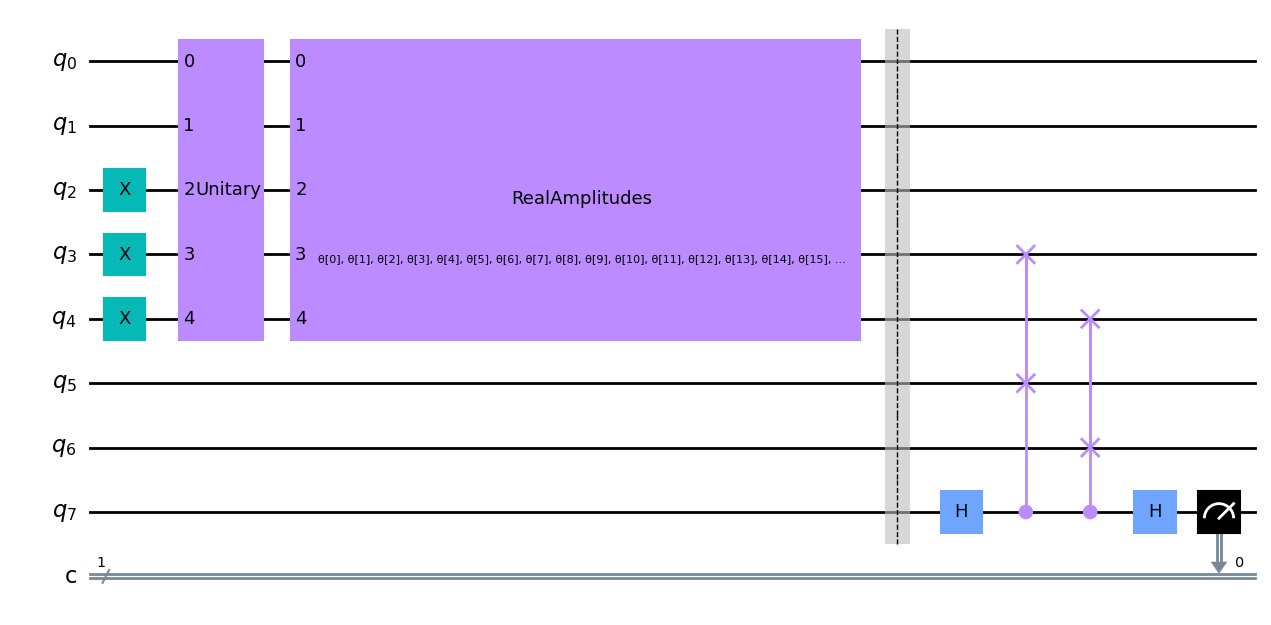

In [82]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [8]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [9]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

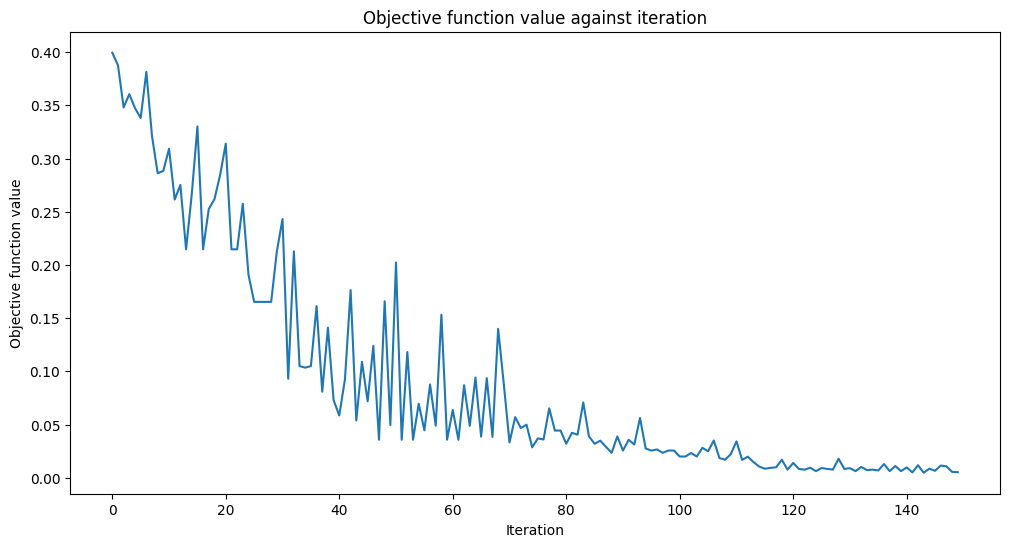

Fit in 8.83 seconds


In [11]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

In [78]:
opt_result.x

array([ 2.01427763,  2.40936016,  0.2146867 ,  0.99036023,  2.03046934,
        0.04110537,  0.55103087,  0.94937206,  0.48027035,  0.32889186,
        1.55885499,  0.35718271,  1.95675327,  0.03545981,  0.39603375,
        1.23112602,  0.11953064,  0.15558295, -0.14841162, -0.09632555,
       -0.3000918 ,  0.20777151,  0.66830925,  1.61232516,  1.74736482,
        0.78072903,  0.5902553 ,  0.4437412 , -0.02379735, -0.18228443])